<a href="https://colab.research.google.com/github/Vadiman728/fully-connected-neural-network/blob/main/%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя датасет по рукописным буквам английского языка, обучите модель, оцените ее предсказательные способности. Используйте только полносвязанные слои. Поэкспериментируйте с числом слоев и числом нейронов в слое, добейтесь максимальной точности. Используйте куски кода и рекомендации из практической части урока. Нарисуйте графики точности и потерь для обучающей и тестовой выборки, сделайте по ним выводы.

# Импортируем датасет

In [ ]:
import numpy as np
dataset = np.loadtxt('https://storage.yandexcloud.net/academy.ai/A_Z_Handwritten_Data.csv', delimiter=',')

In [ ]:
X = dataset[:,1:785]
Y = dataset[:,0]

In [ ]:
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Немножко разведки и просмотра распредления изображений

<ipython-input-4-345c6d01b830>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  im = plt.subplot(5, 8, i+1)


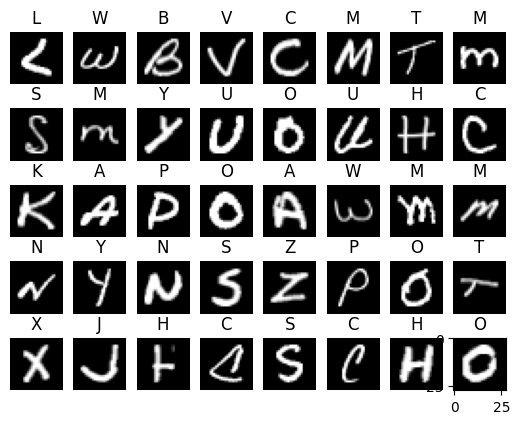

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}

for i in range(40):
    x = x_train[i]
    x = x.reshape((28, 28))
    plt.axis('off')
    im = plt.subplot(5, 8, i+1)
    plt.title(word_dict.get(y_train[i]))
    im.imshow(x, cmap='gray')


In [ ]:
x_train.shape

(297960, 784)

Посмотрим на то, насколько они распредлены по меткам

In [ ]:
# Создаем словарь, в который будем накапливать количество изображений по ключу
quantity_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0, 25:0}
# Пишем цикл, который будет получать индекс изображения и в соответствии с ним плюсовать его в словарь
for i in range(0, len(x_train)):
  x = int(y_train[i])
  quantity_dict[x] = quantity_dict[x] + 1

print(quantity_dict)


{0: 11081, 1: 6999, 2: 18717, 3: 8133, 4: 9094, 5: 945, 6: 4620, 7: 5815, 8: 889, 9: 6799, 10: 4533, 11: 9199, 12: 9934, 13: 15264, 14: 46147, 15: 15444, 16: 4644, 17: 9268, 18: 38737, 19: 17960, 20: 23229, 21: 3321, 22: 8591, 23: 5024, 24: 8703, 25: 4870}


In [ ]:
# создаем новый словарь, где ключами будут буквы из словаря word_dict, а значения из словаря quantity_dict
ratio_dict = {word_dict[key]: value for key, value in quantity_dict.items()}

print(ratio_dict)

{'A': 11081, 'B': 6999, 'C': 18717, 'D': 8133, 'E': 9094, 'F': 945, 'G': 4620, 'H': 5815, 'I': 889, 'J': 6799, 'K': 4533, 'L': 9199, 'M': 9934, 'N': 15264, 'O': 46147, 'P': 15444, 'Q': 4644, 'R': 9268, 'S': 38737, 'T': 17960, 'U': 23229, 'V': 3321, 'W': 8591, 'X': 5024, 'Y': 8703, 'Z': 4870}


Уже видно, что не очень равномерно. Отобразим это в виде столбчатой диаграммы

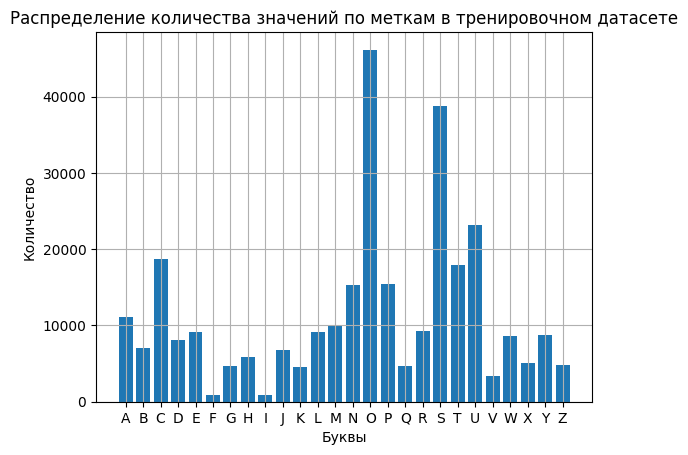

In [ ]:
words = list(ratio_dict.keys()) # получаем буквы в виде списка
quantity = list(ratio_dict.values()) # получаем количество изображений каждой буквы в тренировочном словаре
# строим столбчатую диограмму, где по оси Х будут буквы, а по У будет соответствующее количество
plt.bar(words, quantity)
plt.xlabel("Буквы")
plt.ylabel("Количество")
plt.title("Распределение количества значений по меткам в тренировочном датасете")
plt.grid(True) # подключим сетку для наглядности
plt.show()

На графике наглядно видно, что модели будет трудновато с буквами F и I, когда O и S будет вполне достаточно, чтобы научиться определять их. Также видно, что количество изображений по большинство буквам не доходит до 10 тысяч и лишь трех переваливает за 20 тысяч. Что-то не очень сбалансированный датасет... Но, если это входит в так называемый Hello world по изучению данных, то так уж и быть

# Работаем с моделью

## Моделирование

Входной слой должен иметь размеры изображений в виде вектора (длину на ширину), а выходной слой 26 по количеству букв в алфавите

In [ ]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

И скомпилируем это всё

In [ ]:
model.compile(optimizer='rmsprop',
 loss='categorical_crossentropy',
 metrics=['accuracy'])

## Подготовка данных

Проверим, а нужно ли менять размер и если надо, то как

In [ ]:
x_train.shape

(297960, 784)

По сути у нас уже вектор. Осталось преобразовать к тензору [0,1]

In [ ]:
x_train = x_train.astype('float32')/ 255
x_test = x_test.astype('float32')/ 255


И кодируем метки. Воспользуемся готовой функцией

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 26) # Кодируем обучающие метки на 10 классов
y_test = to_categorical(y_test, 26)   # Кодируем тестовые метки на 10 классов

# Обучение модели и оценка

## Обучение модели

долгожданный момент. собираем конструктор воедино

In [ ]:
history = model.fit (x_train, y_train, validation_data=(x_test, y_test), epochs=7, batch_size=128)

Epoch 1/7
2328/2328 [==============================] - 38s 16ms/step - loss: 0.2385 - accuracy: 0.9312 - val_loss: 0.1070 - val_accuracy: 0.9694
Epoch 2/7
2328/2328 [==============================] - 42s 18ms/step - loss: 0.0880 - accuracy: 0.9741 - val_loss: 0.0929 - val_accuracy: 0.9738
Epoch 3/7
2328/2328 [==============================] - 40s 17ms/step - loss: 0.0641 - accuracy: 0.9813 - val_loss: 0.0872 - val_accuracy: 0.9767
Epoch 4/7
2328/2328 [==============================] - 37s 16ms/step - loss: 0.0503 - accuracy: 0.9855 - val_loss: 0.0755 - val_accuracy: 0.9814
Epoch 5/7
2328/2328 [==============================] - 38s 16ms/step - loss: 0.0436 - accuracy: 0.9876 - val_loss: 0.0745 - val_accuracy: 0.9832
Epoch 6/7
2328/2328 [==============================] - 38s 16ms/step - loss: 0.0403 - accuracy: 0.9887 - val_loss: 0.0693 - val_accuracy: 0.9849
Epoch 7/7
2328/2328 [==============================] - 37s 16ms/step - loss: 0.0391 - accuracy: 0.9896 - val_loss: 0.0781 - val_ac

Точность большая, 5-ти эпох было бы достаточно вполне. Перейдем к графикам, но сначала сделаем предсказание

## Предсказание ⭐

меня смутила 27 картинка. Проверим-ка её

In [ ]:
# Выбор нужной картинки из тестовой выборки
n = 27
x = x_test[n]

# Проверка формы данных
print(x.shape)

(784,)


In [ ]:
import numpy as np

# Массив из одного примера, так как нейронка принимает именно массивы примеров (батчи) для распознавания
x = np.expand_dims(x, axis=0)

# Проверка формы данных
print(x.shape)

(1, 784)


In [ ]:
# Предсказываем выбранную картинку
prediction = model.predict(x)

# Вывод результата - вектор из 10 чисел
print(f'Вектор результата на 10 выходных нейронах: {prediction}')

# Получение и вывод индекса самого большого элемента (это значение цифры, которую распознала сеть)
pred = np.argmax(prediction)
print(f'Распознана буква: {pred}')
print(f'Правильное значение: {np.argmax(y_test[n])}')

1/1 [==============================] - 0s 120ms/step
Вектор результата на 10 выходных нейронах: [[0.0000000e+00 2.9320068e-38 0.0000000e+00 1.4892229e-30 1.1933669e-34
  0.0000000e+00 7.7960512e-34 0.0000000e+00 0.0000000e+00 6.2757202e-24
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8720405e-32
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7886558e-27
  0.0000000e+00]]
Распознана буква: 18
Правильное значение: 18


А, ну да, они же закодированы в цифры... Но, модель все равно справилась

## Визуализация

Я думаю, построим график потерь, точности, и , если получится, матрицу ошибок(отклонения, кто там как её уже не называет, ох уж этот богатый русский язык. В общем, confusion matrix)

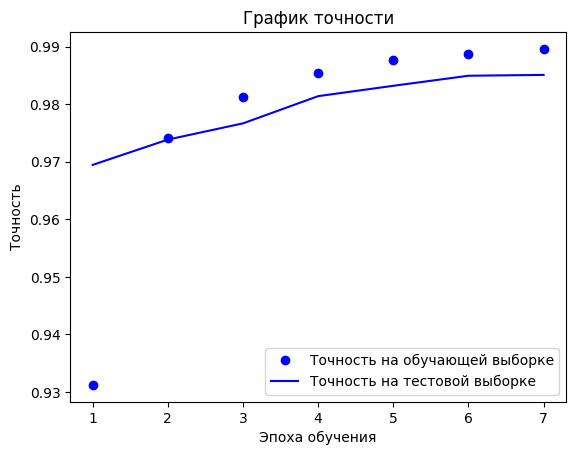

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Точность на обучающей выборке')
plt.plot(epochs, val_acc_values, 'b', label='Точность на тестовой выборке')
plt.title('График точности')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

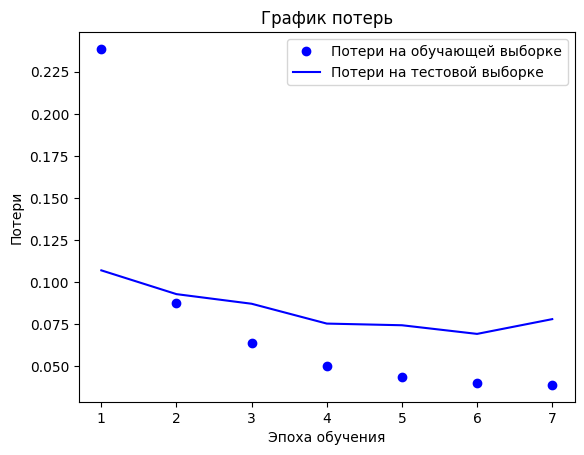

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Потери на обучающей выборке')
plt.plot(epochs, val_loss_values, 'b', label='Потери на тестовой выборке')
plt.title('График потерь')
plt.xlabel('Эпоха обучения')
plt.ylabel('Потери')
plt.legend()
plt.show()

По графикам, кстати, видно, что модель, имея такую высокую точность, даже не переобучена. Потрясающе

In [ ]:
print(type(y_test))